In [21]:
# Import necessary libraries
import torch
import torch.nn as nn
import numpy as np
import time
# ADDED: Import Levenberg–Marquardt for Marching Cubes
try:
    from skimage import measure
except ImportError:
    print("Error: scikit-image not found. Please install it: pip install scikit-image")
    exit()
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [22]:
# --- 1. Define the Surface (Cheese-like) ---
# Level set function for the cheese-like surface (needs to work with numpy arrays for marching_cubes)
def fd_cheese_numpy(p):
    # Ensure input is a NumPy array for calculation
    if isinstance(p, torch.Tensor):
        p = p.cpu().numpy()
    x, y, z = p[:, 0], p[:, 1], p[:, 2]
    term1 = (4 * x**2 - 1)**2
    term2 = (4 * y**2 - 1)**2
    term3 = (4 * z**2 - 1)**2
    term4 = 16 * (x**2 + y**2 - 1)**2
    term5 = 16 * (x**2 + z**2 - 1)**2
    term6 = 16 * (y**2 + z**2 - 1)**2
    return term1 + term2 + term3 + term4 + term5 + term6 - 16

# Level set function for PyTorch tensors (for autograd)
def fd_cheese_torch(p_tensor):
    x, y, z = p_tensor[:, 0], p_tensor[:, 1], p_tensor[:, 2]
    term1 = (4 * x**2 - 1)**2
    term2 = (4 * y**2 - 1)**2
    term3 = (4 * z**2 - 1)**2
    term4 = 16 * (x**2 + y**2 - 1)**2
    term5 = 16 * (x**2 + z**2 - 1)**2
    term6 = 16 * (y**2 + z**2 - 1)**2
    return term1 + term2 + term3 + term4 + term5 + term6 - 16


# Bounding box for the surface
bbox = np.array([[-1.5, 1.5], [-1.5, 1.5], [-1.5, 1.5]])

# Gradient of the level set function (for normal vector calculation)
# Using PyTorch Autograd
def grad_fd(p_tensor):
    # Ensure requires_grad is True for the input tensor *within this function*
    p_tensor_req_grad = p_tensor.detach().clone().requires_grad_(True)
    psi_val = fd_cheese_torch(p_tensor_req_grad)
    # Compute gradients
    grad_psi = torch.autograd.grad(psi_val.sum(), p_tensor_req_grad, create_graph=False)[0] # create_graph=False often sufficient here
    # Return detached gradient
    return grad_psi.detach()

# Hessian of the level set function (for mean curvature calculation)
# Using PyTorch Autograd
def hessian_fd(p_tensor):
    # Ensure requires_grad is True for the input tensor *within this function*
    p_tensor_req_grad = p_tensor.detach().clone().requires_grad_(True)
    psi_val = fd_cheese_torch(p_tensor_req_grad)
    grad_psi = torch.autograd.grad(psi_val.sum(), p_tensor_req_grad, create_graph=True)[0] # Need create_graph=True to compute gradient of gradient

    hessian_rows = []
    for i in range(p_tensor_req_grad.shape[1]):
        grad_i = grad_psi[:, i].sum() # Sum needed for scalar output to grad
        # retain_graph=True needed as we call grad multiple times on the same part of the graph
        hessian_row = torch.autograd.grad(grad_i, p_tensor_req_grad, retain_graph=True)[0]
        hessian_rows.append(hessian_row)

    hessian_matrix = torch.stack(hessian_rows, dim=1) # Shape (M, 3, 3)
    # Return detached Hessian
    return hessian_matrix.detach()

In [23]:
# --- 2. Sampling using Marching Cubes ---
# Function to generate points on the surface
def generate_surface_points_marching_cubes(num_points, grid_points_per_dim=50):
    print(f"Generating surface points using Marching Cubes (Grid dim: {grid_points_per_dim})...")
    # Create a grid
    x = np.linspace(bbox[0, 0], bbox[0, 1], grid_points_per_dim)
    y = np.linspace(bbox[1, 0], bbox[1, 1], grid_points_per_dim)
    z = np.linspace(bbox[2, 0], bbox[2, 1], grid_points_per_dim)
    grid_x, grid_y, grid_z = np.meshgrid(x, y, z, indexing='ij')

    # Stack grid points into shape (N, 3) for evaluation
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T

    # Evaluate the implicit function on the grid
    try:
        volume = fd_cheese_numpy(grid_points).reshape(grid_x.shape)
    except Exception as e:
        print(f"Error evaluating level set function on grid: {e}")
        return None

    # Perform Marching Cubes
    try:
        verts, faces, normals, values = measure.marching_cubes(volume, level=0.0, spacing=(x[1]-x[0], y[1]-y[0], z[1]-z[0]))
        # Adjust vertex coordinates to match the bounding box origin
        verts += np.array([bbox[0, 0], bbox[1, 0], bbox[2, 0]])
        print(f"Marching Cubes generated {verts.shape[0]} vertices.")
    except Exception as e:
        print(f"Error during Marching Cubes execution: {e}")
        return None

    if verts.shape[0] == 0:
        print("Warning: Marching Cubes did not find any surface vertices. Check bounding box or grid resolution.")
        return None

    # Sample desired number of points from the vertices
    if verts.shape[0] < num_points:
        print(f"Warning: Generated fewer points ({verts.shape[0]}) than requested ({num_points}). Using all generated vertices.")
        points = verts
    else:
        print(f"Sampling {num_points} points from the generated vertices.")
        indices = np.random.choice(verts.shape[0], num_points, replace=False)
        points = verts[indices, :]

    print(f"Final number of points: {points.shape[0]}")
    return torch.tensor(points, dtype=torch.float32).to(device)


In [24]:
# --- 3. Define the Shallow Neural Network ---
class ShallowPINN(nn.Module):
    def __init__(self, num_neurons):
        super().__init__()
        self.hidden_layer = nn.Linear(3, num_neurons) # Input is (x, y, z)
        self.output_layer = nn.Linear(num_neurons, 1, bias=False) # Output is u(x, y, z)
        self.activation = nn.Sigmoid() # Sigmoid activation

        # Initialize weights and biases 
        nn.init.xavier_uniform_(self.hidden_layer.weight)
        nn.init.zeros_(self.hidden_layer.bias)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = self.activation(self.hidden_layer(x))
        x = self.output_layer(x)
        return x


In [25]:
# --- 4. Define Exact Solution and Source Term ---
def exact_solution(p):
    # Handle both numpy and torch tensor inputs
    if isinstance(p, np.ndarray):
        p = torch.tensor(p, dtype=torch.float32, device=device)

    x, y, z = p[:, 0], p[:, 1], p[:, 2]
    return torch.sin(x) * torch.exp(torch.cos(y - z))

def compute_source_term(p_tensor):
    p_tensor.requires_grad_(True)
    u_val = exact_solution(p_tensor)

    # First derivatives (gradient)
    grad_u = torch.autograd.grad(u_val.sum(), p_tensor, create_graph=True)[0]

    # Second derivatives (Laplacian and Hessian components)
    laplacian_u_val = 0
    hessian_rows = []
    for i in range(p_tensor.shape[1]):
        grad_u_i = grad_u[:, i].sum()
        hess_row_i = torch.autograd.grad(grad_u_i, p_tensor, create_graph=True)[0]
        laplacian_u_val += hess_row_i[:, i]
        hessian_rows.append(hess_row_i)
    hessian_u = torch.stack(hessian_rows, dim=1)

    # Compute Geometric quantities (normal n, mean curvature H) from level set
    grad_psi = grad_fd(p_tensor)
    norm_grad_psi = torch.linalg.norm(grad_psi, dim=1, keepdim=True) + 1e-8
    n = grad_psi / norm_grad_psi

    hessian_psi = hessian_fd(p_tensor)
    trace_hess_psi = torch.diagonal(hessian_psi, offset=0, dim1=-2, dim2=-1).sum(-1)
    n_T_Hess_psi_n = torch.einsum('bi,bij,bj->b', n, hessian_psi, n)
    mean_curvature_2H = (trace_hess_psi - n_T_Hess_psi_n) / (norm_grad_psi.squeeze() + 1e-8)

    # Normal derivative: du/dn = grad(u) . n
    dudn = torch.einsum('bi,bi->b', grad_u, n)

    # n^T * Hessian(u) * n
    n_T_Hess_u_n = torch.einsum('bi,bij,bj->b', n, hessian_u, n)

    # Laplace-Beltrami operator: Delta_s u = Delta u - 2H * du/dn - n^T * Hessian(u) * n
    delta_s_u = laplacian_u_val - mean_curvature_2H * dudn - n_T_Hess_u_n

    p_tensor.requires_grad_(False)
    # Detach the result before returning
    return delta_s_u.detach()

In [26]:
# --- 5. Define Loss Function ---
# Cache for geometric quantities to avoid recomputing them constantly
geometry_cache = {}

def compute_loss(network, p_tensor):
    p_tensor_key = tuple(p_tensor.flatten().tolist()) # Create a hashable key

    p_tensor.requires_grad_(True)
    u_pred = network(p_tensor).squeeze() # Ensure u_pred is 1D

    # --- Calculate Delta_s u_pred ---
    # First derivatives (gradient)
    grad_u_pred = torch.autograd.grad(u_pred.sum(), p_tensor, create_graph=True)[0]

    # Second derivatives (Laplacian and Hessian components)
    laplacian_u_pred_val = 0
    hessian_rows_pred = []
    for i in range(p_tensor.shape[1]):
        grad_u_pred_i = grad_u_pred[:, i].sum()
        # Use retain_graph=True only if necessary for subsequent computations
        hess_row_pred_i = torch.autograd.grad(grad_u_pred_i, p_tensor, create_graph=True)[0]
        laplacian_u_pred_val += hess_row_pred_i[:, i]
        hessian_rows_pred.append(hess_row_pred_i)
    hessian_u_pred = torch.stack(hessian_rows_pred, dim=1)

    # --- Reuse Geometric Quantities ---
    # Check cache first
    if p_tensor_key not in geometry_cache:
        # print("Computing geometry...") # Debug print
        with torch.no_grad(): # Geometry calculation doesn't need gradient tracking itself
             p_geom = p_tensor.detach().clone() # Work on detached tensor
             grad_psi = grad_fd(p_geom)
             norm_grad_psi = torch.linalg.norm(grad_psi, dim=1, keepdim=True) + 1e-8
             n = grad_psi / norm_grad_psi

             hessian_psi = hessian_fd(p_geom)
             trace_hess_psi = torch.diagonal(hessian_psi, offset=0, dim1=-2, dim2=-1).sum(-1)
             n_T_Hess_psi_n = torch.einsum('bi,bij,bj->b', n, hessian_psi, n)
             mean_curvature_2H = (trace_hess_psi - n_T_Hess_psi_n) / (norm_grad_psi.squeeze() + 1e-8)
             f_val = compute_source_term(p_geom)
             geometry_cache[p_tensor_key] = (n.clone(), mean_curvature_2H.clone(), f_val.clone())
    else:
        # print("Using cached geometry...") # Debug print
        n, mean_curvature_2H, f_val = geometry_cache[p_tensor_key]
        # Ensure they are on the correct device if loaded from cache
        n = n.to(p_tensor.device)
        mean_curvature_2H = mean_curvature_2H.to(p_tensor.device)
        f_val = f_val.to(p_tensor.device)


    # Normal derivative: du_pred/dn = grad(u_pred) . n
    dudn_pred = torch.einsum('bi,bi->b', grad_u_pred, n)

    # n^T * Hessian(u_pred) * n
    n_T_Hess_u_pred_n = torch.einsum('bi,bij,bj->b', n, hessian_u_pred, n)

    # Laplace-Beltrami operator: Delta_s u_pred
    delta_s_u_pred = laplacian_u_pred_val - mean_curvature_2H * dudn_pred - n_T_Hess_u_pred_n
    # --- End Delta_s u_pred calculation ---

    # Loss: Mean Squared Error of the PDE residual: Delta_s u_pred - f
    loss = torch.mean((delta_s_u_pred - f_val)**2)

    p_tensor.requires_grad_(False) # Detach points
    return loss

In [70]:
# --- 5. Define Loss Function ---
# Cache for geometric quantities to avoid recomputing them constantly
geometry_cache = {}

def compute_loss(network, p_tensor):
    # Use a simpler key for caching if points don't change often during optimization
    # For LBFGS, points are fixed per 'epoch', so cache is effective
    p_tensor_key = id(p_tensor) # Use object ID as key since points are fixed

    # Enable gradient computation for the network forward pass and subsequent derivatives
    p_tensor.requires_grad_(True)
    u_pred = network(p_tensor).squeeze() # Ensure u_pred is 1D

    # --- Calculate Delta_s u_pred ---
    # Calculate derivatives needed for Delta_s u_pred
    # Need gradients of u_pred w.r.t p_tensor

    # First derivatives (gradient of prediction)
    # Need create_graph=True to compute Hessian of prediction later
    grad_u_pred = torch.autograd.grad(u_pred.sum(), p_tensor, create_graph=True)[0]

    # Second derivatives (Laplacian and Hessian of prediction)
    laplacian_u_pred_val = 0
    hessian_rows_pred = []
    for i in range(p_tensor.shape[1]):
        grad_u_pred_i = grad_u_pred[:, i].sum()
        # Need retain_graph=True as we compute grad multiple times
        hess_row_pred_i = torch.autograd.grad(grad_u_pred_i, p_tensor, retain_graph=True)[0]
        laplacian_u_pred_val += hess_row_pred_i[:, i]
        hessian_rows_pred.append(hess_row_pred_i)
    hessian_u_pred = torch.stack(hessian_rows_pred, dim=1)
    # --- Finished computing derivatives of u_pred ---


    # --- Get Geometric Quantities (from cache or compute) ---
    if p_tensor_key not in geometry_cache:
        # print("Computing geometry for loss...") # Debug print
        # Compute geometry using detached inputs as we only need the values
        with torch.no_grad():
            p_geom = p_tensor.detach().clone()
            grad_psi = grad_fd(p_geom) # Uses internal grad but output is detached
            norm_grad_psi = torch.linalg.norm(grad_psi, dim=1, keepdim=True) + 1e-8
            n = grad_psi / norm_grad_psi
            hessian_psi = hessian_fd(p_geom) # Uses internal grad but output is detached
            trace_hess_psi = torch.diagonal(hessian_psi, offset=0, dim1=-2, dim2=-1).sum(-1)
            n_T_Hess_psi_n = torch.einsum('bi,bij,bj->b', n, hessian_psi, n)
            mean_curvature_2H = (trace_hess_psi - n_T_Hess_psi_n) / (norm_grad_psi.squeeze() + 1e-8)
            f_val = compute_source_term(p_geom) # Uses internal grad but output is detached
            geometry_cache[p_tensor_key] = (n.clone(), mean_curvature_2H.clone(), f_val.clone())
    else:
        # print("Using cached geometry for loss...") # Debug print
        n, mean_curvature_2H, f_val = geometry_cache[p_tensor_key]
        # Ensure they are on the correct device
        n = n.to(p_tensor.device)
        mean_curvature_2H = mean_curvature_2H.to(p_tensor.device)
        f_val = f_val.to(p_tensor.device)
    # --- Geometric Quantities ready ---


    # --- Assemble Delta_s u_pred using computed derivatives and geometry ---
    # Normal derivative: du_pred/dn = grad(u_pred) . n
    # grad_u_pred has graph attached, n is detached geometry value
    dudn_pred = torch.einsum('bi,bi->b', grad_u_pred, n)

    # n^T * Hessian(u_pred) * n
    # hessian_u_pred has graph attached, n is detached geometry value
    n_T_Hess_u_pred_n = torch.einsum('bi,bij,bj->b', n, hessian_u_pred, n)

    # Laplace-Beltrami operator: Delta_s u_pred
    # laplacian_u_pred_val, dudn_pred, n_T_Hess_u_pred_n have graph attached
    # mean_curvature_2H is detached geometry value
    delta_s_u_pred = laplacian_u_pred_val - mean_curvature_2H * dudn_pred - n_T_Hess_u_pred_n
    # --- End Delta_s u_pred calculation ---

    # Loss: Mean Squared Error of the PDE residual: Delta_s u_pred - f
    # f_val is detached geometry value
    loss = torch.mean((delta_s_u_pred - f_val)**2)

    # Detach input tensor after use in loss computation if it's not needed elsewhere with grad
    p_tensor.requires_grad_(False)
    return loss

# --- 6. Training Setup ---
N_neurons = 60
M_train = 1000 # Marching cubes might generate many points, sample from them
M_test = 10000
marching_cubes_grid_dim = 100 # Increase for better surface resolution, decrease if too slow/memory intensive
learning_rate = 1.0
max_iter = 500
num_epochs = 1 # LBFGS often converges within one 'epoch' (many internal steps)

# Generate Training and Test Points using Marching Cubes
train_points = generate_surface_points_marching_cubes(M_train, grid_points_per_dim=marching_cubes_grid_dim)
test_points = generate_surface_points_marching_cubes(M_test, grid_points_per_dim=marching_cubes_grid_dim * 2) # Finer grid for testing

if train_points is None or test_points is None:
    print("Point generation failed. Exiting.")
    exit()

# --- Pre-compute geometry for training points ---
print("Pre-computing geometry for training points...")
# Ensure gradients are NOT computed globally here, but functions can enable them internally
p_train_key = id(train_points)
# Use detached tensor for geometry calculation inputs
p_geom_train = train_points.detach().clone()
# Call functions that handle their own grad requirements internally
n_train = grad_fd(p_geom_train) # grad_fd enables/disables grad internally
norm_grad_psi_train = torch.linalg.norm(n_train, dim=1, keepdim=True) + 1e-8 # Use norm of gradient directly
n_train = n_train / norm_grad_psi_train # Re-normalize

hessian_psi_train = hessian_fd(p_geom_train) # hessian_fd enables/disables grad internally
trace_hess_psi_train = torch.diagonal(hessian_psi_train, offset=0, dim1=-2, dim2=-1).sum(-1)
n_T_Hess_psi_n_train = torch.einsum('bi,bij,bj->b', n_train, hessian_psi_train, n_train)
mean_curvature_2H_train = (trace_hess_psi_train - n_T_Hess_psi_n_train) / (norm_grad_psi_train.squeeze() + 1e-8)
f_val_train = compute_source_term(p_geom_train) # compute_source_term enables/disables grad internally

# Store detached tensors in cache
geometry_cache[p_train_key] = (n_train.detach().clone(),
                               mean_curvature_2H_train.detach().clone(),
                               f_val_train.detach().clone())
print("Geometry pre-computation finished.")
# --- End Pre-computation ---


# Initialize Network and Optimizer
pinn_network = ShallowPINN(N_neurons).to(device)
optimizer = torch.optim.LBFGS(pinn_network.parameters(),
                              lr=learning_rate,
                              max_iter=max_iter,
                              history_size=100,
                              line_search_fn="strong_wolfe")


Generating surface points using Marching Cubes (Grid dim: 100)...
Marching Cubes generated 37704 vertices.
Sampling 1000 points from the generated vertices.
Final number of points: 1000
Generating surface points using Marching Cubes (Grid dim: 200)...
Marching Cubes generated 151824 vertices.
Sampling 10000 points from the generated vertices.
Final number of points: 10000
Pre-computing geometry for training points...
Geometry pre-computation finished.


In [71]:
# --- 7. Training Loop ---
start_time = time.time()

iter_count = 0
def closure():
    global iter_count
    optimizer.zero_grad()
    loss = compute_loss(pinn_network, train_points)
    loss.backward() # Compute gradients
    if iter_count % 20 == 0: # Print loss every 20 iterations (LBFGS calls closure many times)
       print(f"  Iter: {iter_count}, Loss: {loss.item():.4e}")
    iter_count +=1
    return loss

print("Starting Training...")
pinn_network.train()
optimizer.step(closure) # Optimizer step triggers multiple closure calls

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

# --- 8. Evaluation ---
pinn_network.eval() # Set model to evaluation mode
# Pre-compute geometry for test points if needed for efficiency, or compute within eval
# For simplicity, recompute here if not cached, though caching is better for large test sets
geometry_cache.clear() # Clear train cache if test points are different

with torch.no_grad():
    u_pred_test = pinn_network(test_points)
    u_exact_test = exact_solution(test_points).unsqueeze(1) # Match shape

    # Calculate relative L2 error
    mean_diff = torch.mean(u_exact_test) - torch.mean(u_pred_test)
    u_pred_test_shifted = u_pred_test + mean_diff

    relative_l2_error = torch.linalg.norm(u_pred_test_shifted - u_exact_test) / torch.linalg.norm(u_exact_test)

print(f"\n--- Evaluation ---")
print(f"Sampling Method: Marching Cubes (grid_dim={marching_cubes_grid_dim})")
print(f"Network: ShallowPINN ({N_neurons} neurons)")
print(f"Optimizer: L-BFGS (lr={learning_rate}, max_iter={max_iter})")
print(f"Training Points: {train_points.shape[0]}")
print(f"Test Points: {test_points.shape[0]}")
print(f"Relative L2 Error on Test Set: {relative_l2_error.item():.4e}")

Starting Training...
  Iter: 0, Loss: 1.9831e+01
  Iter: 20, Loss: 4.0724e+01
  Iter: 40, Loss: 4.2189e-01
  Iter: 60, Loss: 7.6700e-02
  Iter: 80, Loss: 3.6453e-02
  Iter: 100, Loss: 3.1399e-02
Training finished in 0.52 seconds.

--- Evaluation ---
Sampling Method: Marching Cubes (grid_dim=100)
Network: ShallowPINN (60 neurons)
Optimizer: L-BFGS (lr=1.0, max_iter=500)
Training Points: 1000
Test Points: 10000
Relative L2 Error on Test Set: 7.4154e-03


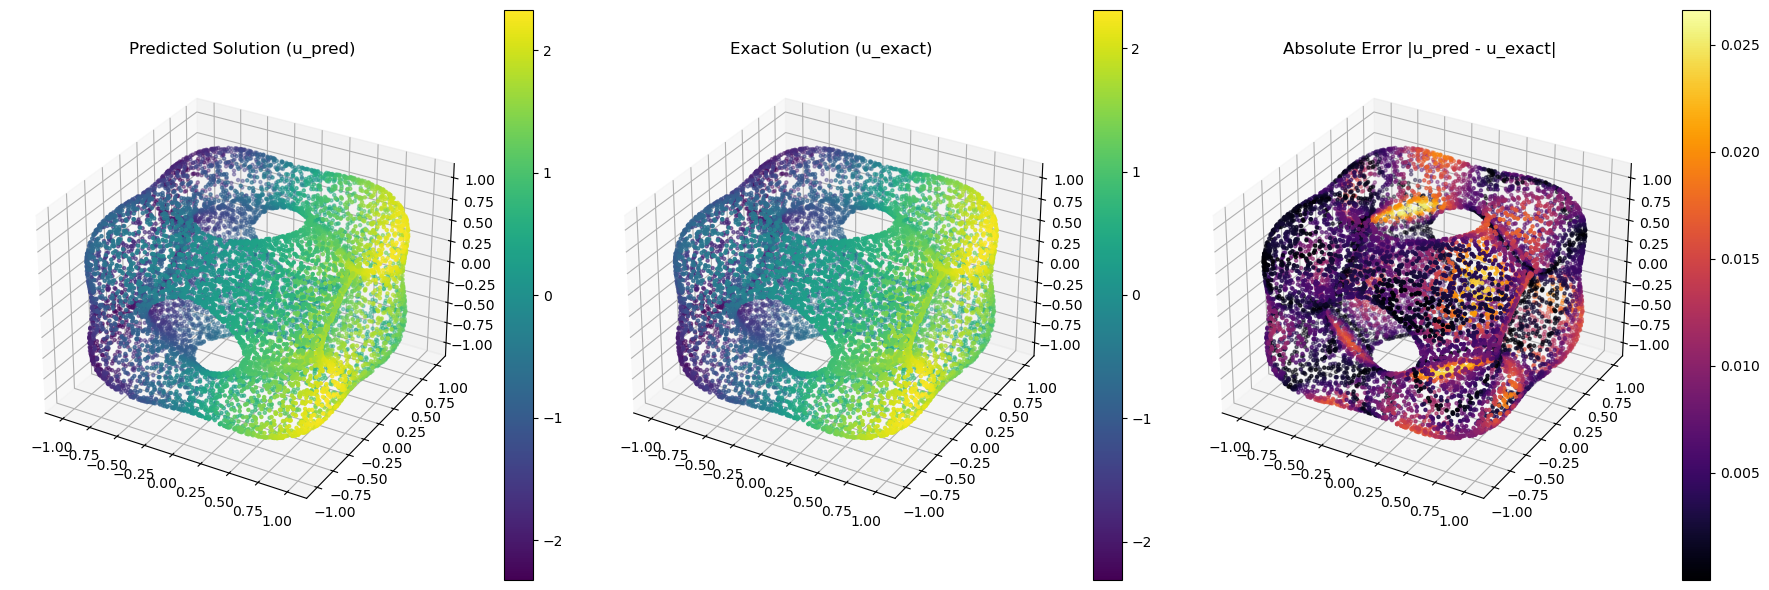

In [72]:
# Visualize results (requires matplotlib)
try:
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(18, 6))

    # Plot Predicted Solution
    ax1 = fig.add_subplot(131, projection='3d')
    p_test_np = test_points.cpu().numpy()
    u_pred_np = u_pred_test_shifted.cpu().numpy().flatten()
    sc1 = ax1.scatter(p_test_np[:, 0], p_test_np[:, 1], p_test_np[:, 2], c=u_pred_np, cmap='viridis', s=5)
    ax1.set_title('Predicted Solution (u_pred)')
    plt.colorbar(sc1, ax=ax1)

    # Plot Exact Solution
    ax2 = fig.add_subplot(132, projection='3d')
    u_exact_np = u_exact_test.cpu().numpy().flatten()
    sc2 = ax2.scatter(p_test_np[:, 0], p_test_np[:, 1], p_test_np[:, 2], c=u_exact_np, cmap='viridis', s=5)
    ax2.set_title('Exact Solution (u_exact)')
    plt.colorbar(sc2, ax=ax2)

    # Plot Absolute Error
    ax3 = fig.add_subplot(133, projection='3d')
    error_np = np.abs(u_pred_np - u_exact_np)
    sc3 = ax3.scatter(p_test_np[:, 0], p_test_np[:, 1], p_test_np[:, 2], c=error_np, cmap='inferno', s=5)
    ax3.set_title('Absolute Error |u_pred - u_exact|')
    plt.colorbar(sc3, ax=ax3)

    plt.tight_layout()
    plt.show()
except ImportError:
    print("\nMatplotlib not found. Skipping visualization.")
except Exception as e:
    print(f"\nError during visualization: {e}")
